![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header = None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [3]:
# EDA for missing values and feature categories

# Better way to detect missing values
columns = cc_apps.columns
for column in columns:
    print(cc_apps[column].unique())

['b' 'a' '?']
['30.83' '58.67' '24.50' '27.83' '20.17' '32.08' '33.17' '22.92' '54.42'
 '42.50' '22.08' '29.92' '38.25' '48.08' '45.83' '36.67' '28.25' '23.25'
 '21.83' '19.17' '25.00' '47.75' '27.42' '41.17' '15.83' '47.00' '56.58'
 '57.42' '42.08' '29.25' '42.00' '49.50' '36.75' '22.58' '27.25' '23.00'
 '27.75' '54.58' '34.17' '28.92' '29.67' '39.58' '56.42' '54.33' '41.00'
 '31.92' '41.50' '23.92' '25.75' '26.00' '37.42' '34.92' '34.25' '23.33'
 '23.17' '44.33' '35.17' '43.25' '56.75' '31.67' '23.42' '20.42' '26.67'
 '36.00' '25.50' '19.42' '32.33' '34.83' '38.58' '44.25' '44.83' '20.67'
 '34.08' '21.67' '21.50' '49.58' '27.67' '39.83' '?' '37.17' '25.67'
 '34.00' '49.00' '62.50' '31.42' '52.33' '28.75' '28.58' '22.50' '28.50'
 '37.50' '35.25' '18.67' '54.83' '40.92' '19.75' '29.17' '24.58' '33.75'
 '25.42' '37.75' '52.50' '57.83' '20.75' '39.92' '24.75' '44.17' '23.50'
 '47.67' '22.75' '34.42' '28.42' '67.75' '47.42' '36.25' '32.67' '48.58'
 '33.58' '18.83' '26.92' '31.25' '56.50' 

In [4]:
# Detecting missing values
cc_apps_NaN = cc_apps.replace('?', np.NaN)

print(cc_apps_NaN.isna().sum().sort_values())

2      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
3      6
4      6
5      9
6      9
0     12
1     12
dtype: int64


In [5]:
cc_apps_NaN[13] = np.where(cc_apps_NaN[13] == '+', 1,0)
cc_apps_NaN[13].unique()

array([1, 0])

In [6]:
# Summary statistics for scaling
warnings.filterwarnings("ignore")
print(cc_apps_NaN.mean())
print('The discrepancy in the means of the numeric features showcases the need for scaling.')

2        4.758725
7        2.223406
10       2.400000
12    1017.385507
13       0.444928
dtype: float64
The discrepancy in the means of the numeric features showcases the need for scaling.


In [7]:
# Approach 1: Not scale the binary one-hot-encoded categorical features 

# Further preprocessing
cc_apps_NaN[1] = cc_apps_NaN[1].astype(float)

# Make a copy
cc_apps_NaN_copy = cc_apps_NaN.copy()

# Split categorical and numerical values
cat_columns = [0, 3, 4, 5, 6, 8, 9, 11]
num_columns = [1, 2, 7, 10, 12]
X_cat = cc_apps_NaN[cat_columns].values
X_num = cc_apps_NaN[num_columns].values
# cc_apps_NaN[13] = np.where(cc_apps_NaN[13] == +, 1,0)
y = cc_apps_NaN[13].values

# Train-test split
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_cat, y, test_size = 0.2, random_state = 69)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size = 0.2, random_state = 69)

# Imputing with SimpleImputer for categorical data the median
imp_cat = SimpleImputer(strategy = 'most_frequent')
X_train_cat = imp_cat.fit_transform(X_train_cat)
X_test_cat = imp_cat.transform(X_test_cat)

# Imputing with SimpleImputer for numeric data the mean value
imp_num = SimpleImputer()
X_train_num = imp_num.fit_transform(X_train_num)
X_test_num = imp_num.transform(X_test_num)

# Scaling to minimize variation of statistic metrics between features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# One-Hot encoding for the categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_cat_enc = encoder.fit_transform(X_train_cat)
X_test_cat_enc = encoder.transform(X_test_cat)

# Appending all features together
X_train = np.append(X_train_num_scaled, X_train_cat_enc, axis = 1)
X_test = np.append(X_test_num_scaled, X_test_cat_enc, axis = 1)
 

# Printing test and train sets
print('The training set after imputation and encoding and scaling is')
print(X_train)
print('\nThe testing set after imputation and encoding and scaling is')
print(y_train)

The training set after imputation and encoding and scaling is
[[-0.2290986  -0.8784957  -0.55982857 ...  0.          0.
   0.        ]
 [ 1.27611934 -0.86142068 -0.5218726  ...  1.          0.
   0.        ]
 [-1.19752614  3.46559083 -0.64788642 ...  0.          1.
   0.        ]
 ...
 [-1.11950921  1.13836574 -0.60993045 ...  0.          0.
   0.        ]
 [-0.92192285  1.10522011 -0.43229651 ...  1.          0.
   0.        ]
 [ 0.22289079 -0.35117884  1.60366179 ...  0.          0.
   0.        ]]

The testing set after imputation and encoding and scaling is
[0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0
 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0
 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 

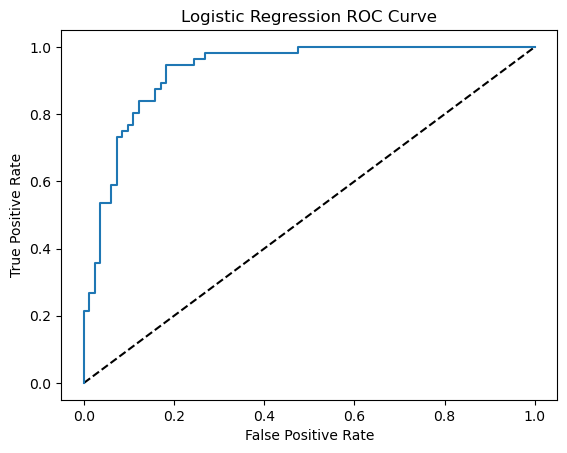

The AUC of the ROC equals to: 0.9292247386759582
The confusion matrix of our model reads: 
 [[67 15]
 [ 6 50]]
Model's Accuracy: 0.8478260869565217


In [29]:
# Training Logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Determine probabilities from the positive group
y_pred_probs = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Plot the ROC Curve 
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

#Determine the best parameter
print('The AUC of the ROC equals to:', roc_auc_score(y_test, y_pred_probs))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"The confusion matrix of our model reads: \n {conf_matrix}")

# Compute accuracy
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print(f"Model's Accuracy: {accuracy}")

In [30]:
# Hyperparameter tuning for logistic regression

warnings.filterwarnings("ignore")

kf = KFold(n_splits = 6, shuffle = True, random_state = 69)
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.linspace(0.001,1, 20),
              'solver': ['lbfgs', 'liblinear', 'saga']
             }
logreg_cv = GridSearchCV(logreg, param_grid, cv=kf)
logreg_cv.fit(X_train, y_train)
print(logreg_cv.best_params_, logreg_cv.best_score_)

{'C': 0.3164736842105263, 'penalty': 'l1', 'solver': 'saga'} 0.8623188405797101


In [23]:
# Hyperparameter tuning for KNN 

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

kf = KFold(n_splits = 6, random_state = 69, shuffle = True)
param_grid = {'n_neighbors':np.arange(1,100,1)}
knn=KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = kf)
knn_cv.fit(X_train, y_train)

print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 13} 0.842391304347826


In [32]:
# Models comparison with GridSearchCV
warnings.filterwarnings("ignore")

models = {
    "Logistic Regression": (LogisticRegression(), {'penalty': ['l1', 'l2', 'elasticnet','none'],
                                                   'C': np.linspace(0.001, 1, 20),
                                                   'solver': ['lbfgs', 'liblinear', 'saga']}),
    "KNN": (KNeighborsClassifier(), {'n_neighbors': np.arange(1, 50)}),
    "Decision Tree": (DecisionTreeClassifier(), {'criterion': ['gini', 'entropy'],
                                                 'max_depth': np.arange(1, 20)})
}

model_scores = {}
results = []
kf = KFold(n_splits=6, random_state=69, shuffle=True)

for model_name, (model, param_grid) in models.items():
    model_cv = GridSearchCV(model, param_grid, cv=kf)
    model_cv.fit(X_train, y_train)
    # Print the best parameters and scores for each model
    print(f"{model_name}: Best Params: {model_cv.best_params_}, Best Score: {model_cv.best_score_}")
    model_scores[model_name] =  model_cv.best_score_

Logistic Regression: Best Params: {'C': 0.3164736842105263, 'penalty': 'l1', 'solver': 'saga'}, Best Score: 0.8623188405797101
KNN: Best Params: {'n_neighbors': 13}, Best Score: 0.842391304347826
Decision Tree: Best Params: {'criterion': 'gini', 'max_depth': 1}, Best Score: 0.8568840579710143


In [15]:
# Finding the best score
best_model = max(model_scores, key=model_scores.get)

# Get the maximum value (best score)
best_score = model_scores[best_model]

print(f'Best model:{best_model}')
print(f'Best Accuracy:{best_score}')

Best model:Logistic Regression
Best Accuracy:0.8605072463768116


In [16]:
# Approach 2: Scale the binary one-hot-encoded categorical features 

# Train-test split
X_train_cat1, X_test_cat1, y_train1, y_test1 = train_test_split(X_cat, y, test_size = 0.2, random_state = 69)
X_train_num1, X_test_num1, y_train1, y_test1 = train_test_split(X_num, y, test_size = 0.2, random_state = 69)

# Imputing with SimpleImputer for categorical data the median
imp_cat = SimpleImputer(strategy = 'most_frequent')
X_train_cat1 = imp_cat.fit_transform(X_train_cat1)
X_test_cat1 = imp_cat.transform(X_test_cat1)

# Imputing with SimpleImputer for numeric data the mean value
imp_num = SimpleImputer()
X_train_num1 = imp_num.fit_transform(X_train_num1)
X_test_num1 = imp_num.transform(X_test_num1)

# One-Hot encoding for the categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_cat_enc1 = encoder.fit_transform(X_train_cat1)
X_test_cat_enc1 = encoder.transform(X_test_cat1)

# Appending all features together
X_train1 = np.append(X_train_num1, X_train_cat_enc1, axis = 1)
X_test1 = np.append(X_test_num1, X_test_cat_enc1, axis = 1)
 
# Scaling to minimize variation of statistic metrics between features
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)
X_test_scaled1 = scaler.transform(X_test1)

# Printing test and train sets
print('The training set after imputation and encoding and scaling is')
print(X_train_scaled1)
print('\nThe testing set after imputation and encoding and scalingh is')
print(X_test_scaled1)

The training set after imputation and encoding and scaling is
[[-0.2290986  -0.8784957  -0.55982857 ... -0.86100228 -0.12126781
  -0.31211457]
 [ 1.27611934 -0.86142068 -0.5218726  ...  1.16143711 -0.12126781
  -0.31211457]
 [-1.19752614  3.46559083 -0.64788642 ... -0.86100228  8.24621125
  -0.31211457]
 ...
 [-1.11950921  1.13836574 -0.60993045 ... -0.86100228 -0.12126781
  -0.31211457]
 [-0.92192285  1.10522011 -0.43229651 ...  1.16143711 -0.12126781
  -0.31211457]
 [ 0.22289079 -0.35117884  1.60366179 ... -0.86100228 -0.12126781
  -0.31211457]]

The testing set after imputation and encoding and scalingh is
[[-0.80913751 -0.78709411  0.009511   ... -0.86100228 -0.12126781
  -0.31211457]
 [ 0.06007285 -0.45162014 -0.26832671 ... -0.86100228 -0.12126781
  -0.31211457]
 [-1.31794357 -0.886531   -0.64788642 ...  1.16143711 -0.12126781
  -0.31211457]
 ...
 [ 1.71369255 -0.54402615 -0.19241477 ... -0.86100228 -0.12126781
  -0.31211457]
 [ 0.90129887 -0.6022821  -0.64788642 ... -0.86100228 

In [28]:
# Comparing models accuracies for scaled binary one-hot encoded features
warnings.filterwarnings("ignore")

model_scores1 = {}
results1 = []
kf = KFold(n_splits=6, random_state=69, shuffle=True)

for model_name, (model, param_grid) in models.items():
    model_cv1 = GridSearchCV(model, param_grid, cv=kf)
    model_cv1.fit(X_train1, y_train1)
    # Print the best parameters and scores for each model
    print(f"{model_name}: Best Params: {model_cv1.best_params_}, Best Score: {model_cv1.best_score_}")
    model_scores1[model_name] =  model_cv1.best_score_

Logistic Regression: Best Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}, Best Score: 0.8641304347826085
KNN: Best Params: {'n_neighbors': 16}, Best Score: 0.7119565217391305
Decision Tree: Best Params: {'criterion': 'gini', 'max_depth': 1}, Best Score: 0.8568840579710143


In [19]:
# Finding the best score
best_model1 = max(model_scores1, key=model_scores1.get)

# Get the maximum value (best score)
best_score1 = model_scores1[best_model1]
# Comparison of approaches
a = best_score1 > best_score

print(f'Best model:{best_model1}')
print(f'Best Accuracy:{best_score1}')
print(f'Approach 2 provides a higher accuracy than Approach 1: {a}!')

Best model:Logistic Regression
Best Accuracy:0.8641304347826085
Approach 2 provides a higher accuracy than Approach 1: True!
